# Clustering Data Intelligently in Python

In [1]:
import matplotlib
%matplotlib inline
%config inlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive
from collections import defaultdict

import hdbscan
import folium
import re

In [2]:
cols = ['#e6194b','#3cb44b','#ffe119','#4363d8','#f58231','#911eb4','#46f0f0',
'#f032e6','#bcff0c',"#fabebe",'#008080','#e6beff','#9a6324','#fffac8','#800000',
'#aaffc3','#808000','#ffd8b1','#000075','#808080'] * 10    # colors

### Task 1 : Exploratory Data Analysis

In [3]:
df = pd.read_csv("taxi_data.csv") 
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [4]:
df.duplicated(subset=['LON','LAT']).values.any()

True

In [5]:
df.isna().values.any()

True

In [6]:
print(f'Before dropping NaNs and dupes \t\tdf.shape= {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON','LAT'],keep='first',inplace=True)
print(f'After dropping NaNs and dupes \t\tdf.shape= {df.shape}')

Before dropping NaNs and dupes 		df.shape= (838, 3)
After dropping NaNs and dupes 		df.shape= (823, 3)


In [7]:
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


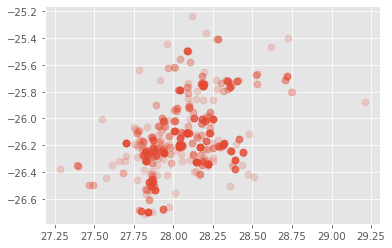

In [8]:
X = np.array(df[['LON','LAT']],dtype='float64')
plt.scatter(X[:,0],X[:,1],alpha=0.2,s=50)

### Task 2 : Visualizing Geographical Data

In [9]:
m = folium.Map(location=[df.LAT.mean(),df.LON.mean()],zoom_start=9,tiles='Stamen Toner')

In [10]:
for _,row in df.iterrows():
    folium.CircleMarker(
      location = [row.LAT, row.LON],
      radius = 5,
      popup = re.sub(r'[^a-zA-Z]+',"",row.NAME),
      color = '#1787FE',
      fill = True,
      fill_colour = '#1787FE'
  ).add_to(m)

In [11]:
m

### Task 3 : Clustering Strength/ Performance Metric

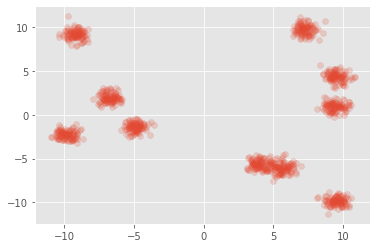

In [12]:
X_blobs, _ = make_blobs(n_samples=1000,centers=10,n_features=2,
cluster_std=0.5,random_state=4)
plt.scatter(X_blobs[:,0],X_blobs[:,1],alpha=0.2)

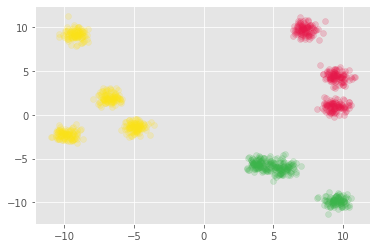

In [13]:
class_predictions = np.load("sample_clusters.npy")
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X=X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0],X[:,1],alpha=0.2,c=cols[unique_cluster])

In [14]:
silhouette_score(X_blobs,class_predictions)

0.6657220862867241

### Task 4 : K-Means Clustering

In [15]:
X_blobs,_ = make_blobs(n_samples=1000,centers=10,n_features=2,cluster_std=0.5,random_state=4)
data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=3,random_state=17,max_iter = x,n_init=1).fit(X_blobs)
    data[x]['class_predictions']=model.predict(X_blobs)
    data[x]['centroids']=model.cluster_centers_
    data[x]['unique_classes']=np.unique(class_predictions)

In [16]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']
    for unique_class in unique_classes:
        plt.scatter(X_blobs[class_predictions==unique_class][:,0],
                   X_blobs[class_predictions==unique_class][:,1],
                   alpha=0.3,c=cols[unique_class])
        plt.scatter(centroids[:,0],centroids[:,1],s=200,c="#000000")
        plt.ylim([-15,15]);plt.ylim([-15,15])
        plt.title("How K-Means Clusters")

In [17]:
interactive_plot = interactive(f,x=(1,20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [18]:
X = np.array(df[['LON','LAT']],dtype='float64')
k = 70
model = KMeans(n_clusters=k,random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans {k}']=class_predictions
df.head()

,LON,LAT,NAME,CLUSTER_kmeans 70
0,28.17858,-25.73882,11th Street Taxi Rank,1
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank,1
2,27.83239,-26.53722,Adams Road Taxi Rank,9
3,28.12514,-26.26666,Alberton City Mall Taxi Rank,8
4,28.10144,-26.10567,Alexandra Main Taxi Rank,4


In [19]:
def create_map(df,cluster_column):
    m = folium.Map(location=[df.LAT.mean(),df.LON.mean()],
                  zoom_start=9,tiles="Stamen Toner")
    for _,row in df.iterrows():
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        cluster_colour = cols[row[cluster_column]]
    folium.CircleMarker(
        location = [row['LAT'],row['LON']],
        radius = 5,
        popup = row[cluster_column],
        color = cluster_colour,
        fill = True,
        fill_colour = cluster_colour
    ).add_to(m)
    return m

In [20]:
m = create_map(df,'CLUSTER_kmeans 70')
print(f'k={k}')
print(f"Silhouette Score: {silhouette_score(X,class_predictions)}")
m.save('kmeans_70.html')

k=70
Silhouette Score: 0.6527069281516621


In [21]:
m

In [22]:
best_silhouette,best_k=-1,0
for k in tqdm(range(2,100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    curr_silhouette = silhouette_score(X,class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
print(f"k = {best_k}")
print(f"Silhouette Score : {best_silhouette}")

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:44<00:00,  2.19it/s]

k = 99
Silhouette Score : 0.708499624089545


### Task 5 : DBSCAN

Density Based Spatial Clustering of Application with Noise

In [23]:
# code for indexing out certian values
dummy = np.array([-1,-1,-1,2,3,4,-1])
new = np.array([(counter+2)*X if X==-1 else X for counter,X in enumerate(dummy)])
model = DBSCAN(eps=0.01,min_samples=5).fit(X)
class_predictions = model.labels_
df['CLUSTER_DBSCAN'] = class_predictions
m = create_map(df,'CLUSTER_DBSCAN')
print(f"Number of Cluster Found : {len(np.unique(class_predictions))}")
print(f"Number of Outlier Found : {len(class_predictions[class_predictions==-1])}")
print(f"Silhouette ignoring outlier : {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}")
no_outlier = 0
no_outlier = np.array([(counter+2)*X if X==-1 else X for counter,X in enumerate(class_predictions)])
print(f'Silhouette outliers as single tons : {silhouette_score(X,no_outlier)}')

Number of Cluster Found : 51
Number of Outlier Found : 289
Silhouette ignoring outlier : 0.923213824804447
Silhouette outliers as single tons : 0.5667489347252957


In [24]:
m

### Task 6 : HDBSCAN

Hierarchial DBSCAN

In [25]:
model = hdbscan.HDBSCAN(min_cluster_size=5,min_samples=2,cluster_selection_epsilon=0.01)
class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions
print(f"Number of Cluster Found : {len(np.unique(class_predictions))-1}")
print(f"Number of Outlier Found : {len(class_predictions[class_predictions==-1])}")
print(f"Silhouette ignoring outlier : {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}")
no_outlier = 0
no_outlier = np.array([(counter+2)*X if X==-1 else X for counter,X in enumerate(class_predictions)])
print(f'Silhouette outliers as single tons : {silhouette_score(X,no_outlier)}')

Number of Cluster Found : 66
Number of Outlier Found : 102
Silhouette ignoring outlier : 0.7670504354649553
Silhouette outliers as single tons : 0.6389924831127337


In [26]:
m

In [27]:
hdbscan.HDBSCAN?

### Task 7 : Address Outliers

In [28]:
classifier = KNeighborsClassifier(n_neighbors=1)
df_train = df[df.CLUSTER_HDBSCAN!=-1]
df_predict = df[df.CLUSTER_HDBSCAN==-1]

X_train = np.array(df_train[['LON','LAT']],dtype='float64')
Y_train = np.array(df_train['CLUSTER_HDBSCAN'])
X_predict = np.array(df_train[['LON','LAT']],dtype='float64')
classifier.fit(X_train,Y_train)

KNeighborsClassifier(n_neighbors=1)

In [29]:
predictions = classifier.predict(X_predict)
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']
m = create_map(df,'CLUSTER_hybrid')
m

In [30]:
class_predictions = df.CLUSTER_hybrid
print(f"Number of Cluster Found : {len(np.unique(class_predictions))}")
print(f"Silhouette : {silhouette_score(X,class_predictions)}")
m.save('hybrid.html')

Number of Cluster Found : 67
Silhouette : 0.5686171939646796


Text(0.5, 0, 'Cluster Sizes')

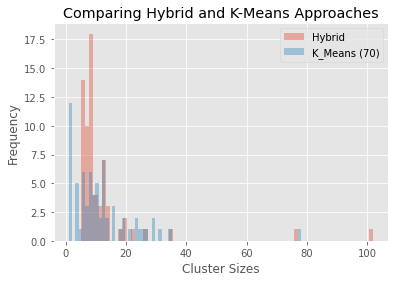

In [31]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70,alpha=0.4,label='Hybrid')
df['CLUSTER_kmeans 70'].value_counts().plot.hist(bins=70,alpha=0.4,label='K_Means (70)')
plt.legend()
plt.title("Comparing Hybrid and K-Means Approaches")
plt.xlabel("Cluster Sizes")